## Introduction

Lettuce (Lactuca sativa) is a widely cultivated leafy green vegetable, prized for its nutritional value and crisp texture. The optimal growth of lettuce relies on a balanced supply of essential nutrients, with **Nitrogen (N)**, **Phosphorus (P)**, and **Potassium (K)** playing crucial roles. Monitoring and addressing nutrient deficiencies are pivotal for maximizing crop yield and quality.

This notebook explores the application of deep learning, specifically fine-tuning a **pre-trained ResNet50** model, to predict NPK (Nitrogen, Phosphorus, and Potassium) deficiencies in lettuce plants. 

<!-- Early detection of NPK deficiencies allows for timely intervention, such as adjusting nutrient levels or applying appropriate treatments, which can significantly impact crop yield and quality. -->

## Data Source:

The dataset used in this project is the [Lettuce NPK dataset](https://www.kaggle.com/datasets/baronn/lettuce-npk-dataset/) available on Kaggle, comprising a comprehensive collection of lettuce images with annotated NPK deficiency labels.

## Objectives:

1. **Data Collection and Preprocessing:** Loading the dataset and Preprocess the data to ensure compatibility with the ResNet50 model.

2. **Transfer Learning with ResNet50:** Fine-tune the pre-trained ResNet50 model on the "Lettuce NPK dataset."

3. **Model Evaluation:** Validate the model's ability to accurately predict NPK deficiencies in unseen lettuce images.

## Imports
Importing relevant librairies (You probably already know them all) and defining some global variables.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
from PIL import Image
import torch
import torch.nn as nn 

IMG_DIR = "/Users/chloeeee/Desktop/EE4002D/Sem2/ML/NPK/FNNPK"  # The dataset directory
MODEL_PATH = '/Users/chloeeee/Desktop/EE4002D/Sem2/ML/NPK/lettuce_npk_resnet18.pth'  # Path for model saving

## Data Collection and Preprocessing

### Organization of the dataset Folder

Fisrt let us visualize the dataset folder (`IMGDIR`). The images in the folder are organised into 4 different sub-folders (-K, -N, -P, FN), each one corresponding to one class, i.e. one nutrient deficiency.
- **-K:** lettuces with K deficiency
- **-N:** lettuces with N deficiency
- **-P:** lettuces with P deficiency
- **FN (Fully Nutritional):** Fully Nutritional lettuces.

The following script allow to visualize some images.

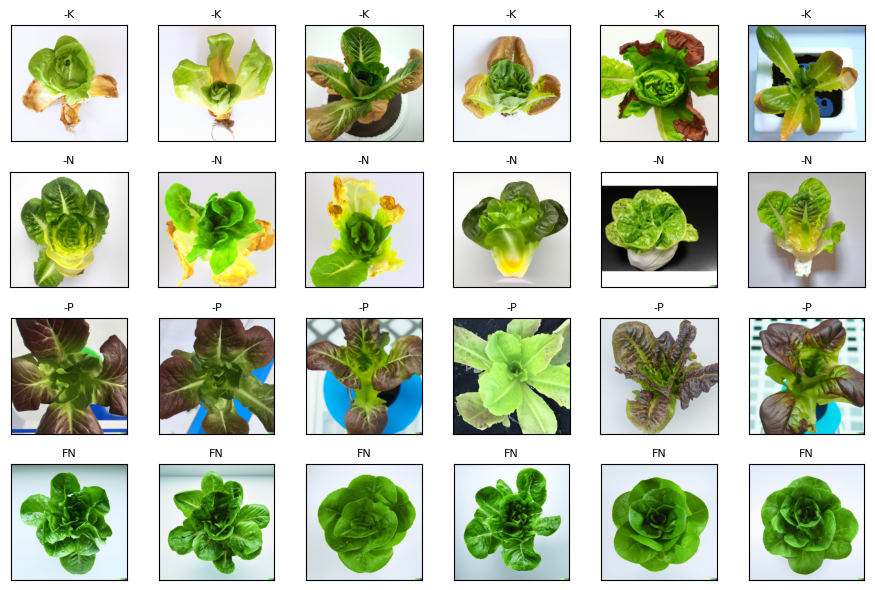

In [5]:
# class_names = sorted(os.listdir(IMG_DIR))
# nrows = len(class_names)
# ncols = 6
# plt.figure(figsize=(ncols*1.5, nrows*1.5))
# for row in range(nrows):
#     class_name = class_names[row]
#     img_paths = [os.path.join(IMG_DIR, class_name, filename)
#         for filename in os.listdir(os.path.join(IMG_DIR, class_name))]
#     for col in range(ncols):
#         plt.subplot(nrows, ncols, row*ncols + col + 1)
#         img = plt.imread(img_paths[col])
#         plt.imshow(img)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(class_name, fontsize=8)
# plt.tight_layout()
# plt.show()

# ✅ 过滤掉 `.DS_Store` 或其他非文件夹的内容
class_names = sorted([f for f in os.listdir(IMG_DIR) if os.path.isdir(os.path.join(IMG_DIR, f))])

# ✅ 设置行数（类别数量）和列数（每行 6 张）
nrows = len(class_names)
ncols = 6

plt.figure(figsize=(ncols * 1.5, nrows * 1.5))

for row, class_name in enumerate(class_names):
    class_dir = os.path.join(IMG_DIR, class_name)
    img_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]  # 只读取图片文件

    if len(img_files) == 0:
        print(f"⚠️ 类别 {class_name} 目录为空，跳过")
        continue  # 如果某个类别没有图片，跳过

    img_paths = [os.path.join(class_dir, filename) for filename in img_files]

    for col in range(min(ncols, len(img_paths))):  # ✅ 只绘制可用的图片
        plt.subplot(nrows, ncols, row * ncols + col + 1)
        img = Image.open(img_paths[col])
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(class_name, fontsize=8)

plt.tight_layout()
plt.show()

### Data Loading and preprocessing
We use the `ImageFolder` object of the Pytorch library in order to load the dataset. This object allows to load the images from the image directory while using the sub-folder as image labels.

Image are also resized to 224x224, the input size for Resnet50 model. We also apply some transformation/augmentation to the images (such as rotation and cropping) in order to improve the image diversity and the robusteness of the model.

In [7]:
# For image resizing and rotation
transform = transforms.Compose([transforms.Resize(255, antialias=True),
                                transforms.CenterCrop(224),
                                transforms.RandomRotation(180),
                                transforms.ToTensor(),])
# Loading the dataset
dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
# train_set, val_set, test_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))
print("classes:", dataset.classes)
print("class labels:", [dataset.class_to_idx[c] for c in dataset.classes])
print("number of images:", len(dataset.imgs))
print(dataset.imgs[0]) # (image path, class label)

classes: ['-K', '-N', '-P', 'FN']
class labels: [0, 1, 2, 3]
number of images: 208
('/Users/chloeeee/Desktop/EE4002D/Sem2/ML/NPK/FNNPK/-K/k_1.png', 0)


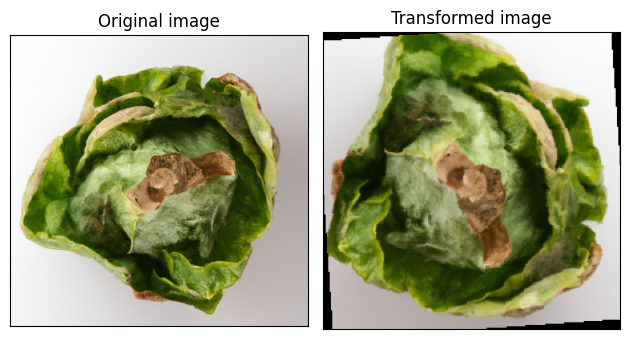

In [9]:
img_path, label = dataset.imgs[2]
original_img = Image.open(img_path)
transformed_img = transform(original_img)
imgs = [original_img, transformed_img]

plt.subplot(1, 2, 1)
plt.imshow(np.asarray(original_img))
plt.xticks([])
plt.yticks([])
plt.title("Original image")
plt.subplot(1, 2, 2)
transformed_img = torch.moveaxis(transformed_img, 0, -1) # change shape from (3, 224, 224) to (224, 224, 3)
plt.imshow(np.asarray(transformed_img))
plt.xticks([])
plt.yticks([])
plt.title("Transformed image")
plt.tight_layout()
plt.show()

Visualising class imbalance

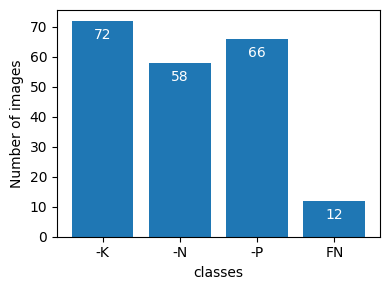

In [11]:
plt.figure(figsize=(4, 3))
class_counts = {class_name: len(os.listdir(os.path.join(IMG_DIR, class_name))) for class_name in dataset.classes}

b = plt.bar(class_counts.keys(), class_counts.values())
plt.bar_label(b, class_counts.values(), color="white", padding=-15)
plt.ylabel("Number of images")
plt.xlabel("classes")
plt.tight_layout()
plt.show()

## Transfer Learning with ResNet50

In [13]:
# Use GPU if available
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

    device

### Function to load the ResNet model

We replace the final layer, Fully Connected (FC) layer, by 2 FC layers and setting the output size to our number of classes (4).

In [15]:
# from torchvision.models import resnet50, ResNet50_Weights
# def get_resnet50():
#     model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
#     model.fc = torch.nn.Sequential(
#         torch.nn.Linear(model.fc.in_features, 100),
#         torch.nn.ReLU(),
#         torch.nn.Linear(100, 4),
#         torch.nn.Softmax()
#     )
#     return model

from torchvision.models import resnet18, ResNet18_Weights

def get_resnet18():
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # ✅ 改为 ResNet18
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(model.fc.in_features, 100),  # ✅ 保持你的隐藏层
        torch.nn.ReLU(),
        torch.nn.Linear(100, 4),  # ✅ 输出 4 类
        torch.nn.Softmax(dim=1)  # ✅ Softmax 需要 `dim=1`
    )
    return model


### Function for fine-tuning the model

In [17]:
# def finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=None, checkpoint_epochs=5, max_epochs_without_imp=2):
#   history = {
#       "loss": {
#           "train": [],
#           "val": []
#       },
#       "accuracy": {
#           "train": [],
#           "val": []
#       }
#   }
#   epochs_without_imp = 0
#   for epoch in range(1, epochs+1):
#     print(f"Epoch {epoch}/{epochs}", end="\t-\t")

#     model.train()  # put network in train mode for Dropout and Batch Normalization
#     train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
#     train_accuracy = torch.tensor(0., device=device)
#     for X, y in train_dataloader:
#       X = X.to(device)
#       y = y.to(device)
#       ypred = model(X)
#       loss = loss_function(ypred, y)
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#       with torch.no_grad():
#         train_loss += loss*train_dataloader.batch_size
#         train_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

#     history["loss"]["train"].append(train_loss.item()/len(train_dataloader.dataset))
#     history["accuracy"]["train"].append(train_accuracy.item()/len(train_dataloader.dataset))
#     print(f"train loss: {history['loss']['train'][-1]:.2f}", end=", ")
#     print(f"train acc: {history['accuracy']['train'][-1]:.2f}", end="\t-\t")

#     if val_dataloader is not None:
#       model.eval()
#       val_loss = torch.tensor(0., device=device)
#       val_accuracy = torch.tensor(0., device=device)
#       with torch.no_grad():
#         for X, y in val_dataloader:
#           X = X.to(device)
#           y = y.to(device)
#           ypred = model(X)
#           loss = loss_function(ypred, y)
#           val_loss += loss * val_dataloader.batch_size
#           val_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

#       history["loss"]["val"].append(val_loss.item()/len(val_dataloader.dataset))
#       history["accuracy"]["val"].append(val_accuracy.item()/len(val_dataloader.dataset))
#       print(f"val loss: {history['loss']['val'][-1]:.2f}", end=", ")
#       print(f"val acc: {history['accuracy']['val'][-1]:.2f}")

#     if epoch >= 2 and history["loss"]["train"][-1] >= history["loss"]["train"][-2]:
#       epochs_without_imp += 1
#     else:
#       epochs_without_imp = 0
#     if epochs_without_imp >= max_epochs_without_imp:
#       break

#   return model, history


def finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=None, checkpoint_epochs=5, max_epochs_without_imp=2):
    history = {
        "loss": {"train": [], "val": []},
        "accuracy": {"train": [], "val": []}
    }
    epochs_without_imp = 0

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}", end="\t-\t")

        model.train()
        train_loss = 0
        train_accuracy = 0

        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            ypred = model(X)
            loss = loss_function(ypred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += loss.item() * len(X)  # ✅ 改成 len(X) 计算
                train_accuracy += (torch.argmax(ypred, dim=1) == y).sum().item()

        history["loss"]["train"].append(train_loss / len(train_dataloader.dataset))
        history["accuracy"]["train"].append(train_accuracy / len(train_dataloader.dataset))
        print(f"train loss: {history['loss']['train'][-1]:.2f}, train acc: {history['accuracy']['train'][-1]:.2f}", end="\t-\t")

        if val_dataloader is not None:
            model.eval()
            val_loss = 0
            val_accuracy = 0
            with torch.no_grad():
                for X, y in val_dataloader:
                    X, y = X.to(device), y.to(device)
                    ypred = model(X)
                    loss = loss_function(ypred, y)

                    val_loss += loss.item() * len(X)  # ✅ 改成 len(X) 计算
                    val_accuracy += (torch.argmax(ypred, dim=1) == y).sum().item()

            history["loss"]["val"].append(val_loss / len(val_dataloader.dataset))
            history["accuracy"]["val"].append(val_accuracy / len(val_dataloader.dataset))
            print(f"val loss: {history['loss']['val'][-1]:.2f}, val acc: {history['accuracy']['val'][-1]:.2f}")

        if epoch >= 2 and history["loss"]["train"][-1] >= history["loss"]["train"][-2]:
            epochs_without_imp += 1
        else:
            epochs_without_imp = 0

        if epochs_without_imp >= max_epochs_without_imp:
            print("🛑 Early Stopping: No improvement in last few epochs.")
            break

    return model, history


### Training

In [21]:
# # splitting the dataset into train val and test
# train_set, val_set, test_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

# # creating data loaders: In this stage, we address class imbalance by sampling 
# # from the various classes inversely proportional to their respective sizes. 
# from torch.utils.data import WeightedRandomSampler

# train_labels = [label for _, label in np.array(dataset.imgs)[train_set.indices]]
# class_counts = dict(zip(*np.unique(train_labels, return_counts=True)))
# samples_weights = np.array([1/class_counts[label] for label in train_labels])
# samples_weights = torch.from_numpy(samples_weights).double()
# sampler = WeightedRandomSampler(samples_weights, len(samples_weights))
# train_dataloader = torch.utils.data.DataLoader(
#     train_set, batch_size=16, num_workers=4, pin_memory=True, sampler=sampler)

# val_labels = [label for _, label in np.array(dataset.imgs)[val_set.indices]]
# class_counts = dict(zip(*np.unique(val_labels, return_counts=True)))
# samples_weights = np.array([1/class_counts[label] for label in val_labels])
# samples_weights = torch.from_numpy(samples_weights).double()
# sampler = WeightedRandomSampler(samples_weights, len(samples_weights))
# val_dataloader = torch.utils.data.DataLoader(
#     val_set, batch_size=16, num_workers=4, pin_memory=True, sampler=sampler)


from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import numpy as np
import torch

# ✅ 1️⃣ 划分数据集
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# ✅ 2️⃣ 获取正确的类别索引
train_labels = [dataset.targets[idx] for idx in train_set.indices]
val_labels = [dataset.targets[idx] for idx in val_set.indices]

# ✅ 3️⃣ 计算每个类别的采样权重
def get_sampler(labels):
    class_counts = dict(zip(*np.unique(labels, return_counts=True)))
    sample_weights = np.array([1 / class_counts[label] for label in labels])
    sample_weights = torch.from_numpy(sample_weights).double()
    return WeightedRandomSampler(sample_weights, len(sample_weights))

# ✅ 4️⃣ 创建 DataLoader
train_dataloader = DataLoader(train_set, batch_size=16, num_workers=4, pin_memory=True, sampler=get_sampler(train_labels))
val_dataloader = DataLoader(val_set, batch_size=16, num_workers=4, pin_memory=True, sampler=get_sampler(val_labels))

# ✅ 5️⃣ 适配 Raspberry Pi（降低 num_workers）
if torch.device("cpu"):
    train_dataloader = DataLoader(train_set, batch_size=16, num_workers=0, pin_memory=False, sampler=get_sampler(train_labels))
    val_dataloader = DataLoader(val_set, batch_size=16, num_workers=0, pin_memory=False, sampler=get_sampler(val_labels))


During the training, we only update the weights of the last layers, layers 3 and 4, and the fully connected layers. Also, we use a smaller learning rate for layers 3 and 4 (to smoothly update their pre-trained weights) compared to the learning rate of the FC layer since its weights are learned from scratch.

In [67]:
# model = get_resnet50().to(device)
# weight_decay, epochs = 1e-4, 25
# optimizer = torch.optim.Adam(
#     [
#         {"params": model.layer3.parameters(), "lr": 1e-4},
#         {"params": model.layer4.parameters(), "lr": 1e-4},
#         {"params": model.fc.parameters(), "lr": 1e-3},
#     ],
#     weight_decay=weight_decay
# )
# loss_function = torch.nn.CrossEntropyLoss()
# model, history = finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=val_dataloader)


import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# ✅ 1️⃣ 定义 ResNet-18 模型
def get_resnet18(num_classes=4):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # ✅ 预训练权重
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # ✅ 修改输出层
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_resnet18().to(device)

# ✅ 2️⃣ 仅微调后几层
for param in model.conv1.parameters():  # 冻结前面层
    param.requires_grad = False
for param in model.layer1.parameters():
    param.requires_grad = False
for param in model.layer2.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = False

# ✅ 确保 `fc` 可训练
for param in model.fc.parameters():
    param.requires_grad = True  

# ✅ 3️⃣ 适配 ResNet-18 的优化器
weight_decay = 1e-4
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=weight_decay)

# ✅ 4️⃣ 训练参数
epochs = 16  # ✅ 适配 Raspberry Pi，防止过拟合
loss_function = nn.CrossEntropyLoss()

# ✅ 5️⃣ 训练
model, history = finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=val_dataloader)


Epoch 1/16	-	train loss: 1.42, train acc: 0.33	-	val loss: 1.18, val acc: 0.45
train loss: 1.23, train acc: 0.44	-	val loss: 1.02, val acc: 0.60
train loss: 1.06, train acc: 0.58	-	val loss: 1.02, val acc: 0.55
train loss: 0.95, train acc: 0.61	-	val loss: 0.86, val acc: 0.75
train loss: 0.82, train acc: 0.82	-	val loss: 0.88, val acc: 0.70
train loss: 0.77, train acc: 0.77	-	val loss: 0.75, val acc: 0.75
train loss: 0.74, train acc: 0.73	-	val loss: 0.76, val acc: 0.70
train loss: 0.62, train acc: 0.84	-	val loss: 0.55, val acc: 0.90
train loss: 0.58, train acc: 0.87	-	val loss: 0.64, val acc: 0.80
train loss: 0.59, train acc: 0.82	-	val loss: 0.48, val acc: 0.90
train loss: 0.51, train acc: 0.90	-	val loss: 0.48, val acc: 0.90
train loss: 0.53, train acc: 0.86	-	val loss: 0.40, val acc: 1.00
train loss: 0.45, train acc: 0.89	-	val loss: 0.60, val acc: 0.80
train loss: 0.50, train acc: 0.89	-	val loss: 0.62, val acc: 0.80
train loss: 0.42, train acc: 0.89	-	val loss: 0.38, val acc: 0.

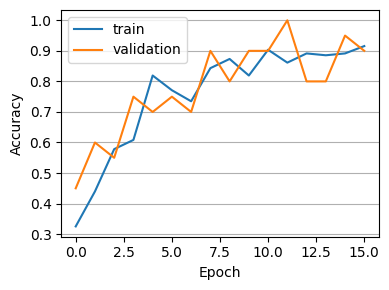

In [69]:
plt.figure(figsize=(4, 3))
plt.plot(history["accuracy"]["train"], label="train")
plt.plot(history["accuracy"]["val"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()

### Saving the model

In [71]:
torch.save(model, MODEL_PATH)

## Model Evaluation

### Accuracy on the test set

In [75]:
#load the saved model
saved_model = torch.load(MODEL_PATH)
saved_model.eval()
# prediction on images from the test set
with torch.no_grad():
    preds = saved_model(torch.stack([x for x, y in test_set]).to(device)).cpu().detach().numpy()
test_labels = np.array([int(label) for _, label in np.array(dataset.imgs)[test_set.indices]])
predicted_labels = np.argmax(preds, axis=1)
accuracy = len(np.where(test_labels==predicted_labels)[0])/len(test_labels)
print("Model accuracy on the test set: {:.2f}".format(accuracy))

Model accuracy on the test set: 0.82


### Visualization

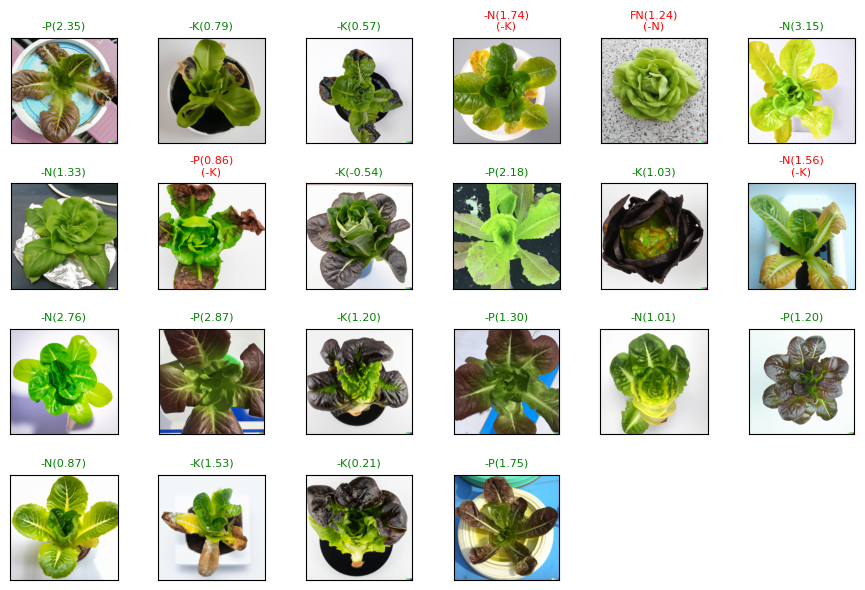

In [78]:
# create a mapping from class labels to class names
classes = dataset.classes
class_names = dict(zip(range(len(classes)), sorted(classes)))

nrows = 4
ncols = 6
nimgs = nrows*ncols
plt.figure(figsize=(ncols*1.5, nrows*1.5))
i = 1
for img_path, label in np.array(dataset.imgs)[test_set.indices][:nimgs]:
    label = int(label)
    class_name = class_names[label]
    pred_label, confidence = np.argmax(preds[i-1]), max(preds[i-1])
    pred_class_name = class_names[pred_label]
    plt.subplot(nrows, ncols, i)
    img_number = col + 1
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(
        f"{pred_class_name}({confidence:.2f})" if pred_label==label else \
        f"{pred_class_name}({confidence:.2f})\n({class_name})",
        fontsize=8, color="green" if pred_label==label else "red"
    )
    i+=1
plt.tight_layout()
plt.show()

### Creating a prediction function
that takes as input an image and predits its class with the corresponding confidence

In [15]:
def prediction(img):
    t = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(224, antialias=True)
    ])
    new_img = t(img)
    model.eval()
    with torch.no_grad():
        pred = model(torch.stack([new_img]).to(device)).cpu().detach().numpy()[0]
    class_label = np.argmax(pred)
    return class_names[np.argmax(pred)], pred[class_label]

i=0
img_path, _ = dataset.imgs[i]
print(img_path)
img = Image.open(img_path)
prediction(img)

/kaggle/input/lettuce-npk-dataset/FNNPK/-K/k_1.png


('-K', 0.9985556)

In [90]:
import torch
import torchvision.models as models

# ✅ 重新创建 ResNet18 并修改最后一层
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 4)  # 4 类

# ✅ 加载之前保存的模型
loaded_model = torch.load("lettuce_npk_resnet18.pth", map_location="cpu")

# ✅ 确保 loaded_model 是模型，而不是 state_dict
if isinstance(loaded_model, torch.nn.Module):
    print("🔍 检测到完整模型，提取 state_dict()")
    state_dict = loaded_model.state_dict()
else:
    print("✅ 直接使用 state_dict")
    state_dict = loaded_model

# ✅ 重新保存 `state_dict`
torch.save(state_dict, "lettuce_npk_resnet18_state_dict.pth")

print("✅ ResNet18 state_dict 保存成功！")


🔍 检测到完整模型，提取 state_dict()
✅ ResNet18 state_dict 保存成功！
